In [23]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker

from notebook_shared import utils

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

INPUT_FILE = "dataset"
FSIZE = "full"
CM = 1/2.54  # centimeters to inches conversion

df = pd.read_parquet(utils.get_dataset_path(INPUT_FILE, FSIZE))

In [24]:
runtime_cov_df = df.groupby( ['provider'])['runtime'].apply(utils.cov).dropna().reset_index(name='Runtime CV').set_index(['provider'])
runtime_cov_df = runtime_cov_df*100
resp_df = df.groupby( ['provider', 'driver_invocation']).size().reset_index(name='counts')

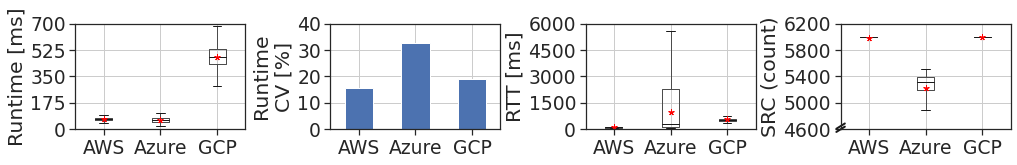

data 
              runtime                                                     \
               count        mean        std    min    25%    50%    75%   
provider                                                                  
AWS       17356677.0   69.076503  10.711193   31.0   62.0   67.0   75.0   
AZURE     15178984.0   62.759923  20.410365   24.0   51.0   64.0   73.0   
GCP       17399939.0  481.646313  92.050537  105.0  434.0  476.0  534.0   

                  roundTripTime                                           \
              max         count        mean          std     min     25%   
provider                                                                   
AWS        1855.0    17356677.0  125.927253   678.183618   57.98   99.84   
AZURE     13352.0    15178984.0  974.357431  1217.238140   55.49  121.13   
GCP        8112.0    17399939.0  566.802942   221.952345  181.69  496.13   

                                      
             50%      75%        max  
provide

In [25]:
factor=2
sns.set(font_scale=1.7)
sns.set_style("ticks",{'axes.grid' : True})

# Plot Coefficient Of Variation Per Cloud Provider:
fig, axes = plt.subplots(figsize=(17.7*CM*factor, 2.5*CM*factor), ncols=4, nrows=1, frameon=False, sharex=True)
max_nticks = 5

runtime_bx_ax = axes[0]
runtime_cov_ax = axes[1]
roundtrip_bx_ax = axes[2]
respcount_bx_ax = axes[3]

def set_provider_labels(x):
    label = x.get_text()[1:].split(',')[0]
    if label == "AZURE":
        label = "Azure"
    return label

# Runtime COV
runtime_cov_df.plot(kind='bar', ax=runtime_cov_ax)
runtime_cov_ax.set_xlabel('')
runtime_cov_ax.set_ylabel('Runtime\nCV [%]')
runtime_cov_ax.get_legend().remove()
# quick fix:
labels = runtime_cov_ax.get_xticklabels()
labels[1].set_text('Azure')
runtime_cov_ax.set_xticklabels(labels, rotation=0)

#
ax = runtime_cov_ax
ax.set_ylim(min(ax.get_yticks()), max(ax.get_yticks()))
ax.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(max_nticks))

# Boxplot Runtime
df_boxplot = df[['provider', 'runtime']].sort_values(by=['provider']).groupby(['provider'], observed=True)
ax = utils.boxplot(runtime_bx_ax, df_boxplot, 'Runtime [ms]', set_provider_labels, with_mean=True, nticks=max_nticks)
ax.set_ylim(0, 700)

# Boxplot RTT
df_boxplot = df[['provider', 'roundTripTime']].sort_values(by=['provider']).groupby(['provider'], observed=True)
ax = utils.boxplot(roundtrip_bx_ax, df_boxplot, 'RTT [ms]', set_provider_labels, with_mean=True, nticks=max_nticks)
ax.set_ylim(0, 6000)

# Boxplot Successfull Responses
df_boxplot = resp_df[['provider', 'counts']].sort_values(by=['provider']).groupby(['provider'], observed=True)
ax = utils.boxplot(respcount_bx_ax, df_boxplot, 'SRC (count)', set_provider_labels, with_mean=True, nticks=max_nticks)
ax.set_ylim(4600, 6200)

d = .025  # how big to make the diagonal lines in axes coordinates
shift = 0.03

# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=2)
# bottom-left diagonal
ax.plot((-d, +d), (-d, +d), **kwargs)
# bottom-left diagonal
ax.plot((-d, +d), (-d+shift, +d+shift), **kwargs)

fig.tight_layout(pad=0)
plt.subplots_adjust(hspace=0, wspace=0.5)

data = df[['provider', 'runtime', 'roundTripTime']].groupby(['provider'], observed=True).describe()
utils.plot(['provider_analysis', 'pa_provider_mean_cov'], 
            data=data,
            respdata=resp_df.groupby(['provider']).describe(),
            runtime_cv=runtime_cov_df.groupby(['provider']).describe()
          )

In [ ]:
rtt_cov_df = df.groupby( ['provider'], observed=True)['roundTripTime'].apply(utils.cov).dropna().reset_index(name='Round Trip Time CV').set_index(['provider'])
rtt_cov_df

In [ ]:
rtt_cov_df.groupby('provider')
fig, axes = plt.subplots(figsize=(5,5))
    
bxdf = rtt_cov_df.reset_index().groupby(['provider'])
rtt_cov_df.plot.bar(ax=axes)

utils.savefig(fig, ['provider_analysis', f'rtt_cv_boxplot'], data=rtt_cov_df)